# Multi-Objective Bayesian Optimization for LightGBM Spectral-to-Descriptor Models

This notebook implements multi-objective Bayesian optimization using Ax and BoTorch for hyperparameter tuning of LightGBM models for spectral-to-descriptor prediction.

## Mathematical Framework

### Multi-Objective Optimization Problem

For each molecular descriptor $d \in \mathcal{D}$, we solve:

$$\mathbf{x}^*_d = \arg\max_{\mathbf{x} \in \mathcal{X}} [f_1^d(\mathbf{x}), -f_2^d(\mathbf{x})]$$

Where:
- $f_1^d(\mathbf{x})$ = R² score for descriptor $d$ (maximize)
- $f_2^d(\mathbf{x})$ = RMSE for descriptor $d$ (minimize, hence negated)
- $\mathcal{X}$ = LightGBM hyperparameter search space
- $\mathcal{D}$ = Set of 12 molecular descriptors

### Gaussian Process Surrogate Model

Each objective is modeled with a Gaussian Process:

$$f_i^d(\mathbf{x}) \sim \mathcal{GP}(\mu_i^d(\mathbf{x}), k_i^d(\mathbf{x}, \mathbf{x}'))$$

### Batch Acquisition Function

We use qNEHVI (quasi-Noisy Expected Hypervolume Improvement) for batch acquisition:

$$\alpha_{qNEHVI}(\mathbf{X}) = \mathbb{E}[HV(\mathcal{P} \cup f(\mathbf{X})) - HV(\mathcal{P})]$$

Where $\mathcal{P}$ is the current Pareto frontier and $HV$ is the hypervolume indicator.

## 1. Environment Setup and Thread Control

Set environment variables before importing numerical libraries to prevent thread oversubscription.

In [10]:
# Prevent thread oversubscription for parallel processing
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import json
import pickle
import warnings
import logging
from typing import Dict, Any, Tuple, List, Optional, Union
from datetime import datetime
from dataclasses import dataclass, field
from pathlib import Path
import time

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from joblib import Parallel, delayed

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Force CPU usage for torch (MPS doesn't work with BoTorch)
torch.set_default_device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(-1)  # Disable CUDA
    
# Ax and BoTorch imports - using correct imports to avoid deprecation warnings
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.generation_strategy.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Generators
from ax.core.optimization_config import MultiObjectiveOptimizationConfig
from ax.core.objective import MultiObjective, Objective
from ax.core.metric import Metric
from ax.core.outcome_constraint import ObjectiveThreshold
from ax.core.types import ComparisonOp

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

logger.info(f"Environment setup complete. CPU count: {os.cpu_count()}")
logger.info(f"Torch device: {torch.get_default_device() if hasattr(torch, 'get_default_device') else 'cpu'}")
logger.info("BoTorch will run on CPU (required for stability)")

2025-08-21 08:22:20,235 - INFO - Environment setup complete. CPU count: 16
2025-08-21 08:22:20,236 - INFO - Torch device: cpu
2025-08-21 08:22:20,236 - INFO - BoTorch will run on CPU (required for stability)


## 2. Configuration Dataclass

Using dataclasses for clean configuration management following SOLID principles.

In [11]:
@dataclass
class OptimizationConfig:
    """Configuration for Bayesian optimization of LightGBM models."""
    # Data paths
    data_dir: Path = Path('../data/processed')
    models_dir: Path = Path('../models/bayesian_optimized_lgb')
    results_dir: Path = Path('../data/results/hpo_lgb')
    dataset: str = 'hpj'
    
    # Target descriptors - all 12
    descriptors: List[str] = field(default_factory=lambda: [
        'MolWt', 'HeavyAtomCount', 'NumHeteroatoms',
        'NumAromaticRings', 'RingCount', 'NOCount',
        'NumHDonors', 'NumHAcceptors', 'TPSA',
        'MolLogP', 'NumRotatableBonds', 'FractionCsp3'
    ])
    
    # Which descriptors to optimize (None = all)
    optimize_descriptors: Optional[List[str]] = None
    
    # Data processing
    validation_split: float = 0.2
    random_state: int = 42
    
    # Optimization settings
    n_iterations: int = 50
    n_initial_points: int = 14  # Sobol initialization
    batch_size: int = 8  # Parallel evaluations
    
    # Speed optimization
    row_subsample_frac: float = 0.5  # Subsample for faster evaluation
    early_stopping_rounds: int = 50
    
    # Multi-objective settings
    objectives: List[str] = field(default_factory=lambda: ['r2', 'rmse'])
    minimize: List[bool] = field(default_factory=lambda: [False, True])
    
    def __post_init__(self):
        self.models_dir.mkdir(parents=True, exist_ok=True)
        self.results_dir.mkdir(parents=True, exist_ok=True)
        if self.optimize_descriptors is None:
            self.optimize_descriptors = self.descriptors.copy()
    
    def get_data_path(self) -> Path:
        return self.data_dir / self.dataset

config = OptimizationConfig()
# Optimize ALL 12 descriptors
config.optimize_descriptors = config.descriptors.copy()
logger.info(f"Will optimize {len(config.optimize_descriptors)} descriptors: {config.optimize_descriptors}")

2025-08-21 08:22:20,294 - INFO - Will optimize 12 descriptors: ['MolWt', 'HeavyAtomCount', 'NumHeteroatoms', 'NumAromaticRings', 'RingCount', 'NOCount', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'MolLogP', 'NumRotatableBonds', 'FractionCsp3']


## 3. Data Loading and Preprocessing

Load preprocessed spectral data and molecular descriptors.

In [12]:
class DataLoader:
    """Handles data loading and preprocessing for spectral-to-descriptor task."""
    
    @staticmethod
    def load_jsonl(filepath: Path) -> List[Dict]:
        """Load data from JSONL file."""
        if not filepath.exists():
            raise FileNotFoundError(f"File not found: {filepath}")
        
        data = []
        with open(filepath, 'r') as f:
            for line in tqdm(f, desc=f"Loading {filepath.name}"):
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError:
                    continue
        
        logger.info(f"Loaded {len(data)} samples from {filepath.name}")
        return data
    
    @staticmethod
    def extract_features_and_targets(data: List[Dict], 
                                    descriptor_names: List[str]) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """Extract spectral features and descriptor targets."""
        X = np.array([sample['spectrum'] for sample in data])
        y_all = np.array([sample['descriptors'] for sample in data])
        
        # Create mapping of descriptor names to indices
        descriptor_indices = {name: i for i, name in enumerate(descriptor_names)}
        
        return X, y_all, descriptor_indices
    
    @staticmethod
    def prepare_data(config: OptimizationConfig) -> Dict[str, Any]:
        """Load and prepare all data."""
        data_path = config.get_data_path()
        
        # Load all three splits
        train_data = DataLoader.load_jsonl(data_path / 'train_data.jsonl')
        val_data = DataLoader.load_jsonl(data_path / 'val_data.jsonl')
        test_data = DataLoader.load_jsonl(data_path / 'test_data.jsonl')
        
        # Load metadata
        with open(data_path / 'metadata.json', 'r') as f:
            metadata = json.load(f)
        
        # Extract features and targets
        X_train, y_train, desc_indices = DataLoader.extract_features_and_targets(
            train_data, config.descriptors
        )
        X_val, y_val, _ = DataLoader.extract_features_and_targets(
            val_data, config.descriptors
        )
        X_test, y_test, _ = DataLoader.extract_features_and_targets(
            test_data, config.descriptors
        )
        
        # Create subsampled validation for fast evaluation
        rng = np.random.RandomState(config.random_state)
        n_subsample = int(len(X_val) * config.row_subsample_frac)
        row_idx = rng.choice(len(X_val), n_subsample, replace=False)
        
        X_val_sub = X_val[row_idx]
        y_val_sub = y_val[row_idx]
        
        # Create feature names for consistency with LightGBM
        feature_names = [f'mz_{i}' for i in range(X_train.shape[1])]
        
        return {
            'X_train': X_train,
            'X_val': X_val,
            'X_val_sub': X_val_sub,
            'X_test': X_test,
            'y_train': y_train,
            'y_val': y_val,
            'y_val_sub': y_val_sub,
            'y_test': y_test,
            'descriptor_indices': desc_indices,
            'metadata': metadata,
            'feature_names': feature_names
        }

# Load data
data = DataLoader.prepare_data(config)
logger.info(f"Data shapes - Train: {data['X_train'].shape}, Val: {data['X_val'].shape}, Test: {data['X_test'].shape}")
logger.info(f"Subsampled val for fast eval: {data['X_val_sub'].shape}")
logger.info(f"Spectrum dimensionality: {data['X_train'].shape[1]}")
logger.info(f"Number of descriptors: {data['y_train'].shape[1]}")

Loading train_data.jsonl: 0it [00:00, ?it/s]

2025-08-21 08:22:20,811 - INFO - Loaded 2176 samples from train_data.jsonl


Loading val_data.jsonl: 0it [00:00, ?it/s]

2025-08-21 08:22:21,019 - INFO - Loaded 272 samples from val_data.jsonl


Loading test_data.jsonl: 0it [00:00, ?it/s]

2025-08-21 08:22:21,062 - INFO - Loaded 272 samples from test_data.jsonl
2025-08-21 08:22:21,115 - INFO - Data shapes - Train: (2176, 500), Val: (272, 500), Test: (272, 500)
2025-08-21 08:22:21,115 - INFO - Subsampled val for fast eval: (136, 500)
2025-08-21 08:22:21,115 - INFO - Spectrum dimensionality: 500
2025-08-21 08:22:21,116 - INFO - Number of descriptors: 12


## 4. Metrics Computation

Metrics for evaluating descriptor prediction performance.

In [13]:
class MetricsComputer:
    """Compute evaluation metrics for descriptor prediction."""
    
    @staticmethod
    def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Compute regression metrics."""
        return {
            'r2': float(r2_score(y_true, y_pred)),
            'rmse': float(np.sqrt(mean_squared_error(y_true, y_pred))),
            'mae': float(mean_absolute_error(y_true, y_pred))
        }

## 5. Search Space Definition

Define the hyperparameter search space for LightGBM.

### Search Space Design

We define a comprehensive search space $\mathcal{X}$ for LightGBM covering:

- **Tree structure**: $n_{leaves} \in [10, 100]$, $d_{max} \in [3, 20]$
- **Learning dynamics**: $\eta \in [0.01, 0.3]$, $n_{trees} \in [100, 1000]$
- **Regularization**: $\lambda_{L1} \in [0, 1]$, $\lambda_{L2} \in [0, 1]$
- **Sampling**: $f_{feature} \in [0.5, 1.0]$, $f_{bagging} \in [0.5, 1.0]$

In [14]:
def create_search_space() -> List[Dict[str, Any]]:
    """Create Ax search space for LightGBM."""
    return [
        {
            "name": "n_estimators",
            "type": "range",
            "bounds": [100, 1000],
            "value_type": "int",
            "log_scale": False
        },
        {
            "name": "num_leaves",
            "type": "range",
            "bounds": [10, 100],
            "value_type": "int",
            "log_scale": False
        },
        {
            "name": "max_depth",
            "type": "range",
            "bounds": [3, 20],
            "value_type": "int",
            "log_scale": False
        },
        {
            "name": "learning_rate",
            "type": "range",
            "bounds": [0.01, 0.3],
            "value_type": "float",
            "log_scale": True
        },
        {
            "name": "feature_fraction",
            "type": "range",
            "bounds": [0.5, 1.0],
            "value_type": "float",
            "log_scale": False
        },
        {
            "name": "bagging_fraction",
            "type": "range",
            "bounds": [0.5, 1.0],
            "value_type": "float",
            "log_scale": False
        },
        {
            "name": "bagging_freq",
            "type": "range",
            "bounds": [1, 10],
            "value_type": "int",
            "log_scale": False
        },
        {
            "name": "min_child_samples",
            "type": "range",
            "bounds": [5, 50],
            "value_type": "int",
            "log_scale": False
        },
        {
            "name": "reg_alpha",
            "type": "range",
            "bounds": [0.0, 1.0],
            "value_type": "float",
            "log_scale": False
        },
        {
            "name": "reg_lambda",
            "type": "range",
            "bounds": [0.0, 1.0],
            "value_type": "float",
            "log_scale": False
        },
        {
            "name": "min_split_gain",
            "type": "range",
            "bounds": [0.0, 0.1],
            "value_type": "float",
            "log_scale": False
        }
    ]

## 6. Evaluation Function

The evaluation function trains a LightGBM model for a specific descriptor and returns multiple objectives.

In [15]:
def evaluate_parameters(parameters: Dict[str, Any], 
                        data: Dict[str, np.ndarray],
                        descriptor_idx: int,
                        use_subsample: bool = True) -> Dict[str, Tuple[float, float]]:
    """Evaluate LightGBM with given parameters for a specific descriptor.
    
    Args:
        parameters: Hyperparameters to evaluate
        data: Data dictionary
        descriptor_idx: Index of the descriptor to optimize
        use_subsample: Whether to use subsampled data for faster evaluation
    
    Returns:
        dict with r2 and rmse (mean, sem) tuples
    """
    # Create model
    lgb_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        boosting_type='gbdt',
        n_estimators=parameters['n_estimators'],
        num_leaves=parameters['num_leaves'],
        max_depth=parameters['max_depth'],
        learning_rate=parameters['learning_rate'],
        feature_fraction=parameters['feature_fraction'],
        bagging_fraction=parameters['bagging_fraction'],
        bagging_freq=parameters['bagging_freq'],
        min_child_samples=parameters['min_child_samples'],
        reg_alpha=parameters['reg_alpha'],
        reg_lambda=parameters['reg_lambda'],
        min_split_gain=parameters['min_split_gain'],
        random_state=config.random_state,
        n_jobs=1,  # Avoid nested parallelism
        verbose=-1
    )
    
    # Select target descriptor
    y_train_desc = data['y_train'][:, descriptor_idx]
    
    # Create DataFrames with feature names to avoid sklearn warnings
    X_train_df = pd.DataFrame(data['X_train'], columns=data['feature_names'])
    
    if use_subsample:
        X_val_df = pd.DataFrame(data['X_val_sub'], columns=data['feature_names'])
        y_val_desc = data['y_val_sub'][:, descriptor_idx]
    else:
        X_val_df = pd.DataFrame(data['X_val'], columns=data['feature_names'])
        y_val_desc = data['y_val'][:, descriptor_idx]
    
    # Train with early stopping
    lgb_model.fit(
        X_train_df, y_train_desc,
        eval_set=[(X_val_df, y_val_desc)],
        callbacks=[
            lgb.early_stopping(config.early_stopping_rounds),
            lgb.log_evaluation(0)  # Suppress output
        ]
    )
    
    # Predict and evaluate
    y_pred = lgb_model.predict(X_val_df)
    
    # Compute metrics
    metrics = MetricsComputer.compute_metrics(y_val_desc, y_pred)
    
    return {
        'r2': (metrics['r2'], 0.0),  # (mean, sem)
        'rmse': (metrics['rmse'], 0.0)
    }

# Helper function for parallel evaluation
def _run_eval(params: Dict[str, Any], desc_idx: int) -> Dict[str, Tuple[float, float]]:
    """Wrapper for parallel evaluation."""
    return evaluate_parameters(params, data, desc_idx, use_subsample=True)

## 7. Optimization Function for Single Descriptor

Function to optimize hyperparameters for a single descriptor using multi-objective Bayesian optimization.

In [16]:
def optimize_descriptor(descriptor_name: str, 
                        descriptor_idx: int,
                        config: OptimizationConfig,
                        data: Dict[str, Any]) -> Dict[str, Any]:
    """Optimize hyperparameters for a single descriptor.
    
    Returns:
        Dictionary containing optimization results
    """
    logger.info(f"\n{'='*60}")
    logger.info(f"Starting optimization for descriptor: {descriptor_name}")
    logger.info(f"{'='*60}")
    
    # Initialize Ax client
    ax_client = AxClient(verbose_logging=False)
    
    # Create experiment
    ax_client.create_experiment(
        name=f"lgb_{descriptor_name}_optimization",
        parameters=create_search_space(),
        objectives={
            "r2": ObjectiveProperties(minimize=False),
            "rmse": ObjectiveProperties(minimize=True)
        },
        overwrite_existing_experiment=True,
        immutable_search_space_and_opt_config=False
    )
    
    # Define generation strategy
    gs = GenerationStrategy(
        steps=[
            GenerationStep(
                model=Generators.SOBOL,
                num_trials=config.n_initial_points,
                min_trials_observed=config.n_initial_points
            ),
            GenerationStep(
                model=Generators.BOTORCH_MODULAR,
                num_trials=-1
            )
        ]
    )
    ax_client._generation_strategy = gs
    
    # Storage for results
    trials_data = []
    best_r2 = -np.inf
    best_rmse = np.inf
    
    # Start optimization
    optimization_start_time = time.time()
    pbar = tqdm(total=config.n_iterations, desc=f"Optimizing {descriptor_name}")
    trial_index = 0
    
    # Phase 1: Sobol initialization
    while trial_index < config.n_initial_points:
        batch_size = min(config.batch_size, config.n_initial_points - trial_index)
        
        batch_trials = []
        for _ in range(batch_size):
            parameters, trial_id = ax_client.get_next_trial()
            batch_trials.append((parameters, trial_id))
        
        # Parallel evaluation
        params_list = [params for params, _ in batch_trials]
        raw_list = Parallel(
            n_jobs=min(config.batch_size, os.cpu_count()),
            backend="loky"
        )(delayed(_run_eval)(p, descriptor_idx) for p in params_list)
        
        # Log results
        for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
            try:
                ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
                
                r2 = raw_data['r2'][0]
                rmse = raw_data['rmse'][0]
                
                trials_data.append({
                    'trial_id': trial_id,
                    'parameters': parameters,
                    'r2': r2,
                    'rmse': rmse,
                    'phase': 'sobol'
                })
                
                if r2 > best_r2:
                    best_r2 = r2
                if rmse < best_rmse:
                    best_rmse = rmse
                
                pbar.set_postfix({
                    'Phase': 'Sobol',
                    'Best R²': f'{best_r2:.4f}',
                    'Best RMSE': f'{best_rmse:.4f}'
                })
            except Exception as e:
                logger.error(f"Trial {trial_id} failed: {e}")
                ax_client.log_trial_failure(trial_index=trial_id)
        
        trial_index += batch_size
        pbar.update(batch_size)
    
    # Set objective thresholds
    df_sobol = pd.DataFrame(trials_data)
    r2_threshold = float(np.percentile(df_sobol["r2"], 10))
    rmse_threshold = float(np.percentile(df_sobol["rmse"], 90))
    
    r2_metric = Metric(name="r2")
    rmse_metric = Metric(name="rmse")
    
    ax_client.experiment.optimization_config = MultiObjectiveOptimizationConfig(
        objective=MultiObjective(
            objectives=[
                Objective(metric=r2_metric, minimize=False),
                Objective(metric=rmse_metric, minimize=True),
            ]
        ),
        objective_thresholds=[
            ObjectiveThreshold(
                metric=r2_metric,
                bound=r2_threshold,
                op=ComparisonOp.GEQ,
                relative=False
            ),
            ObjectiveThreshold(
                metric=rmse_metric,
                bound=rmse_threshold,
                op=ComparisonOp.LEQ,
                relative=False
            ),
        ],
    )
    
    # Phase 2: Bayesian optimization
    while trial_index < config.n_iterations:
        batch_size = min(config.batch_size, config.n_iterations - trial_index)
        
        batch_trials = []
        for i in range(batch_size):
            try:
                parameters, trial_id = ax_client.get_next_trial()
                batch_trials.append((parameters, trial_id))
            except Exception as e:
                logger.warning(f"Could not generate trial {i+1}: {e}")
                break
        
        if not batch_trials:
            break
        
        # Parallel evaluation
        params_list = [params for params, _ in batch_trials]
        raw_list = Parallel(
            n_jobs=min(len(params_list), os.cpu_count()),
            backend="loky"
        )(delayed(_run_eval)(p, descriptor_idx) for p in params_list)
        
        # Log results
        for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
            try:
                ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
                
                r2 = raw_data['r2'][0]
                rmse = raw_data['rmse'][0]
                
                trials_data.append({
                    'trial_id': trial_id,
                    'parameters': parameters,
                    'r2': r2,
                    'rmse': rmse,
                    'phase': 'bayesian'
                })
                
                if r2 > best_r2:
                    best_r2 = r2
                    logger.info(f"New best R² for {descriptor_name}: {best_r2:.4f}")
                if rmse < best_rmse:
                    best_rmse = rmse
                
                pbar.set_postfix({
                    'Phase': 'BO',
                    'Best R²': f'{best_r2:.4f}',
                    'Best RMSE': f'{best_rmse:.4f}'
                })
            except Exception as e:
                logger.error(f"Trial {trial_id} failed: {e}")
                ax_client.log_trial_failure(trial_index=trial_id)
        
        trial_index += batch_size
        pbar.update(batch_size)
    
    pbar.close()
    optimization_time = time.time() - optimization_start_time
    
    # Extract best solution
    df_trials = pd.DataFrame(trials_data)
    
    # Select best based on weighted score
    weights = np.array([0.6, 0.4])  # [r2, 1-rmse]
    objectives = np.column_stack([
        df_trials['r2'].values,
        df_trials['rmse'].values
    ])
    
    # Normalize objectives
    normalized_objectives = objectives.copy()
    normalized_objectives[:, 0] = (objectives[:, 0] - objectives[:, 0].min()) / (objectives[:, 0].max() - objectives[:, 0].min() + 1e-8)
    normalized_objectives[:, 1] = (objectives[:, 1].max() - objectives[:, 1]) / (objectives[:, 1].max() - objectives[:, 1].min() + 1e-8)
    
    scores = normalized_objectives @ weights
    best_idx = np.argmax(scores)
    best_trial = df_trials.iloc[best_idx]
    
    logger.info(f"Optimization complete for {descriptor_name}")
    logger.info(f"  Time: {optimization_time:.1f}s")
    logger.info(f"  Best R²: {best_trial['r2']:.4f}")
    logger.info(f"  Best RMSE: {best_trial['rmse']:.4f}")
    
    return {
        'descriptor': descriptor_name,
        'best_parameters': best_trial['parameters'],
        'best_r2': best_trial['r2'],
        'best_rmse': best_trial['rmse'],
        'trials_data': trials_data,
        'optimization_time': optimization_time
    }

## 8. Run Optimization for All Descriptors

Optimize hyperparameters for each of the 12 descriptors.

In [17]:
# Run optimization for each descriptor
optimization_results = {}

logger.info(f"\nStarting optimization for {len(config.optimize_descriptors)} descriptors")
logger.info(f"Descriptors to optimize: {config.optimize_descriptors}")

for descriptor_name in config.optimize_descriptors:
    descriptor_idx = data['descriptor_indices'][descriptor_name]
    
    result = optimize_descriptor(
        descriptor_name=descriptor_name,
        descriptor_idx=descriptor_idx,
        config=config,
        data=data
    )
    
    optimization_results[descriptor_name] = result
    
    # Save intermediate results
    intermediate_path = config.results_dir / f'optimization_{descriptor_name}.pkl'
    with open(intermediate_path, 'wb') as f:
        pickle.dump(result, f)

logger.info("\nAll optimizations complete!")
logger.info(f"Optimized {len(optimization_results)} descriptors")

2025-08-21 08:22:21,454 - INFO - 
Starting optimization for 12 descriptors
2025-08-21 08:22:21,455 - INFO - Descriptors to optimize: ['MolWt', 'HeavyAtomCount', 'NumHeteroatoms', 'NumAromaticRings', 'RingCount', 'NOCount', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'MolLogP', 'NumRotatableBonds', 'FractionCsp3']
2025-08-21 08:22:21,455 - INFO - 
2025-08-21 08:22:21,455 - INFO - Starting optimization for descriptor: MolWt
2025-08-21 08:22:21,456 - INFO - ============================================================
[WARNING 08-21 08:22:21] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:22:21] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:22:21] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generatio

Optimizing MolWt:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 34.1024
Early stopping, best iteration is:
[141]	valid_0's rmse: 33.6367
Did not meet early stopping. Best iteration is:
[765]	valid_0's rmse: 37.9462
Early stopping, best iteration is:
[247]	valid_0's rmse: 31.5892
Did not meet early stopping. Best iteration is:
[375]	valid_0's rmse: 33.1404
Did not meet early stopping. Best iteration is:
[578]	valid_0's rmse: 32.8317
Early stopping, best iteration is:
[232]	valid_0's rmse: 32.6473
Did not meet early 

2025-08-21 08:23:24,221 - INFO - New best R² for MolWt: 0.8878


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[286]	valid_0's rmse: 31.8284
Early stopping, best iteration is:
[345]	valid_0's rmse: 32.445
Early stopping, best iteration is:
[559]	valid_0's rmse: 31.0834
Early stopping, best iteration is:
[325]	valid_0's rmse: 32.9246
Early stopping, best iteration is:
[251]	valid_0's rmse: 31.243
Early stopping, best iteration is:
[306]	valid_0's rmse: 32.5953
Early stopping, best iteration is:
[570]	valid_0's rmse: 31.675
Did not meet early stopping. Best iteration is:
[719]	valid_

2025-08-21 08:24:14,011 - INFO - New best R² for MolWt: 0.8880


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[614]	valid_0's rmse: 31.6243
Did not meet early stopping. Best iteration is:
[585]	valid_0's rmse: 33.4925
Did not meet early stopping. Best iteration is:
[680]	valid_0's rmse: 30.2348
Did not meet early stopping. Best iteration is:
[657]	valid_0's rmse: 29.6663
Did not meet early stopping. Best iteration is:
[720]	valid_0's rmse: 29.7771
Did not meet early stopping. Best iteration is:
[636]	valid_0's rmse: 31.1454
Did not meet early stopping. Best iteration 

2025-08-21 08:25:15,777 - INFO - New best R² for MolWt: 0.8882
2025-08-21 08:25:15,781 - INFO - New best R² for MolWt: 0.8891


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[709]	valid_0's rmse: 30.5213
Did not meet early stopping. Best iteration is:
[702]	valid_0's rmse: 31.8055
Did not meet early stopping. Best iteration is:
[615]	valid_0's rmse: 31.9416
Did not meet early stopping. Best iteration is:
[648]	valid_0's rmse: 31.2071
Did not meet early stopping. Best iteration is:
[739]	valid_0's rmse: 29.6095
Early stopping, best iteration is:
[433]	valid_0's rmse: 34.8194
Did not meet early stopping. Best iteration is:
[699]	val

2025-08-21 08:26:22,255 - INFO - New best R² for MolWt: 0.8895


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[761]	valid_0's rmse: 32.193
Did not meet early stopping. Best iteration is:
[742]	valid_0's rmse: 32.9831
Did not meet early stopping. Best iteration is:
[740]	valid_0's rmse: 31.4128


2025-08-21 08:26:49,270 - INFO - Optimization complete for MolWt
2025-08-21 08:26:49,271 - INFO -   Time: 267.8s
2025-08-21 08:26:49,271 - INFO -   Best R²: 0.8895
2025-08-21 08:26:49,271 - INFO -   Best RMSE: 29.6095
2025-08-21 08:26:49,273 - INFO - 
2025-08-21 08:26:49,273 - INFO - Starting optimization for descriptor: HeavyAtomCount
2025-08-21 08:26:49,273 - INFO - ============================================================
[WARNING 08-21 08:26:49] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:26:49] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:26:49] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 trials, Bo

Did not meet early stopping. Best iteration is:
[767]	valid_0's rmse: 32.6556


Optimizing HeavyAtomCount:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's rmse: 2.59385
Did not meet early stopping. Best iteration is:
[216]	valid_0's rmse: 2.34275
Early stopping, best iteration is:
[125]	valid_0's rmse: 2.48742
Did not meet early stopping. Best iteration is:
[189]	valid_0's rmse: 2.21351
Did not meet early stopping. Best iteration is:
[376]	valid_0's rmse: 2.31164
Early stopping, best iteration is:
[360]	valid_0's rmse: 2.31295
Did not meet early stopping. Best iteration is:
[901]	valid_0's rmse: 2.34687
Did n

2025-08-21 08:27:44,176 - INFO - New best R² for HeavyAtomCount: 0.8837


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[161]	valid_0's rmse: 2.68433
Did not meet early stopping. Best iteration is:
[250]	valid_0's rmse: 2.57281
Did not meet early stopping. Best iteration is:
[231]	valid_0's rmse: 2.64546
Did not meet early stopping. Best iteration is:
[107]	valid_0's rmse: 2.48172
Did not meet early stopping. Best iteration is:
[107]	valid_0's rmse: 3.61055
Did not meet early stopping. Best iteration is:
[151]	valid_0's rmse: 2.46583
Did not meet early stopping. Best iteration 

2025-08-21 08:28:49,396 - INFO - New best R² for HeavyAtomCount: 0.8846


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[203]	valid_0's rmse: 2.29945
Did not meet early stopping. Best iteration is:
[649]	valid_0's rmse: 2.23105
Did not meet early stopping. Best iteration is:
[670]	valid_0's rmse: 2.29902
Did not meet early stopping. Best iteration is:
[837]	valid_0's rmse: 2.27932
Did not meet early stopping. Best iteration is:
[812]	valid_0's rmse: 2.27885
Did not meet early stopping. Best iteration is:
[869]	valid_0's rmse: 2.22001
Did not meet early stopping. Best iteration 

2025-08-21 08:31:15,823 - INFO - New best R² for HeavyAtomCount: 0.8875
2025-08-21 08:31:15,829 - INFO - Optimization complete for HeavyAtomCount
2025-08-21 08:31:15,829 - INFO -   Time: 266.6s
2025-08-21 08:31:15,829 - INFO -   Best R²: 0.8875
2025-08-21 08:31:15,829 - INFO -   Best RMSE: 2.1704
2025-08-21 08:31:15,830 - INFO - 
2025-08-21 08:31:15,831 - INFO - Starting optimization for descriptor: NumHeteroatoms
2025-08-21 08:31:15,831 - INFO - ============================================================
[WARNING 08-21 08:31:15] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:31:15] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:31:15] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation s

Did not meet early stopping. Best iteration is:
[542]	valid_0's rmse: 2.17043


Optimizing NumHeteroatoms:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's rmse: 1.26265
Early stopping, best iteration is:
[241]	valid_0's rmse: 1.09887
Did not meet early stopping. Best iteration is:
[119]	valid_0's rmse: 1.2967
Did not meet early stopping. Best iteration is:
[356]	valid_0's rmse: 1.14814
Early stopping, best iteration is:
[289]	valid_0's rmse: 1.147
Did not meet early stopping. Best iteration is:
[233]	valid_0's rmse: 1.1705
Did not meet early stopping. Best iteration is:
[839]	valid_0's rmse: 1.18499
Did not m

2025-08-21 08:32:26,810 - INFO - New best R² for NumHeteroatoms: 0.6588
2025-08-21 08:32:26,816 - INFO - New best R² for NumHeteroatoms: 0.6727


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[256]	valid_0's rmse: 1.16505
Early stopping, best iteration is:
[354]	valid_0's rmse: 1.0777
Early stopping, best iteration is:
[511]	valid_0's rmse: 1.16688
Early stopping, best iteration is:
[288]	valid_0's rmse: 1.11619
Early stopping, best iteration is:
[92]	valid_0's rmse: 1.17182
Early stopping, best iteration is:
[178]	valid_0's rmse: 1.0515
Early stopping, best iteration is:
[134]	valid_0's rmse: 1.20578
Early stopping, best iteration is:
[274]	valid_0's rmse: 1.1

2025-08-21 08:33:33,056 - INFO - New best R² for NumHeteroatoms: 0.6758


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[308]	valid_0's rmse: 1.13893
Early stopping, best iteration is:
[255]	valid_0's rmse: 1.21211
Early stopping, best iteration is:
[329]	valid_0's rmse: 1.13316
Early stopping, best iteration is:
[233]	valid_0's rmse: 1.14551
Early stopping, best iteration is:
[308]	valid_0's rmse: 1.10395
Early stopping, best iteration is:
[281]	valid_0's rmse: 1.0824
Early stopping, best iteration is:
[284]	valid_0's rmse: 1.13914
Early stopping, best iteration is:
[366]	valid_0's rmse: 1

2025-08-21 08:36:47,483 - INFO - Optimization complete for NumHeteroatoms
2025-08-21 08:36:47,483 - INFO -   Time: 331.6s
2025-08-21 08:36:47,484 - INFO -   Best R²: 0.6758
2025-08-21 08:36:47,484 - INFO -   Best RMSE: 1.0515
2025-08-21 08:36:47,485 - INFO - 
2025-08-21 08:36:47,485 - INFO - Starting optimization for descriptor: NumAromaticRings
2025-08-21 08:36:47,486 - INFO - ============================================================
[WARNING 08-21 08:36:47] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:36:47] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:36:47] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 

Optimizing NumAromaticRings:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 0.414184
Early stopping, best iteration is:
[90]	valid_0's rmse: 0.350598
Early stopping, best iteration is:
[286]	valid_0's rmse: 0.393636
Early stopping, best iteration is:
[296]	valid_0's rmse: 0.344577
Early stopping, best iteration is:
[172]	valid_0's rmse: 0.357549
Early stopping, best iteration is:
[244]	valid_0's rmse: 0.371056
Did not meet early stopping. Best iteration is:
[553]	valid_0's rmse: 0.370195
Did not meet early stoppin

2025-08-21 08:37:37,337 - INFO - New best R² for NumAromaticRings: 0.8814


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.394998
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.415863
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.345582
Early stopping, best iteration is:
[180]	valid_0's rmse: 0.358456
Early stopping, best iteration is:
[161]	valid_0's rmse: 0.363257
Early stopping, best iteration is:
[151]	valid_0's rmse: 0.340926
Early stopping, best iteration is:
[96]	valid_0's rmse: 0.361577
Early stopping, best iteration is:
[260]	valid_0's rms

2025-08-21 08:41:50,101 - INFO - New best R² for NumAromaticRings: 0.8888


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds


2025-08-21 08:42:27,949 - INFO - Optimization complete for NumAromaticRings
2025-08-21 08:42:27,949 - INFO -   Time: 340.5s
2025-08-21 08:42:27,950 - INFO -   Best R²: 0.8888
2025-08-21 08:42:27,950 - INFO -   Best RMSE: 0.3236
2025-08-21 08:42:27,951 - INFO - 
2025-08-21 08:42:27,951 - INFO - Starting optimization for descriptor: RingCount
2025-08-21 08:42:27,952 - INFO - ============================================================
[WARNING 08-21 08:42:27] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:42:27] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:42:27] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 trial

Early stopping, best iteration is:
[178]	valid_0's rmse: 0.338422
Early stopping, best iteration is:
[131]	valid_0's rmse: 0.334237
Early stopping, best iteration is:
[123]	valid_0's rmse: 0.349903
Early stopping, best iteration is:
[180]	valid_0's rmse: 0.357342


Optimizing RingCount:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[116]	valid_0's rmse: 0.574898
Early stopping, best iteration is:
[252]	valid_0's rmse: 0.552497
Early stopping, best iteration is:
[153]	valid_0's rmse: 0.559609
Early stopping, best iteration is:
[306]	valid_0's rmse: 0.563074
Early stopping, best iteration is:
[274]	valid_0's rmse: 0.559033
Did not meet early stopping. Best iteration is:
[508]	valid_0's rmse: 0.590729
Did not meet early stopping. Best iteration is:
[781]	valid_0's rmse: 0.586263
Early stopp

2025-08-21 08:43:16,146 - INFO - New best R² for RingCount: 0.8302


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[186]	valid_0's rmse: 0.566889
Early stopping, best iteration is:
[179]	valid_0's rmse: 0.61671
Did not meet early stopping. Best iteration is:
[119]	valid_0's rmse: 0.591922
Early stopping, best iteration is:
[48]	valid_0's rmse: 0.595846
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.599804
Did not meet early stopping. Best iteration is:
[176]	valid_0's rmse: 0.549299
Early stopping, best iteration is:
[130]	valid_0's rmse: 0.592559
E

2025-08-21 08:46:30,198 - INFO - Optimization complete for RingCount
2025-08-21 08:46:30,199 - INFO -   Time: 242.2s
2025-08-21 08:46:30,199 - INFO -   Best R²: 0.8302
2025-08-21 08:46:30,199 - INFO -   Best RMSE: 0.5311
2025-08-21 08:46:30,200 - INFO - 
2025-08-21 08:46:30,200 - INFO - Starting optimization for descriptor: NOCount
2025-08-21 08:46:30,201 - INFO - ============================================================
[WARNING 08-21 08:46:30] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:46:30] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:46:30] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 trials, BoTorc

Optimizing NOCount:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 1.03991
Early stopping, best iteration is:
[175]	valid_0's rmse: 1.01239
Did not meet early stopping. Best iteration is:
[128]	valid_0's rmse: 0.970448
Early stopping, best iteration is:
[300]	valid_0's rmse: 0.900193
Early stopping, best iteration is:
[265]	valid_0's rmse: 0.946279
Did not meet early stopping. Best iteration is:
[230]	valid_0's rmse: 0.928104
Did not meet early stopping. Best iteration is:
[597]	valid_0's rmse: 0.988018
Early stopping

2025-08-21 08:51:27,529 - INFO - Optimization complete for NOCount
2025-08-21 08:51:27,530 - INFO -   Time: 297.3s
2025-08-21 08:51:27,530 - INFO -   Best R²: 0.6691
2025-08-21 08:51:27,531 - INFO -   Best RMSE: 0.8684
2025-08-21 08:51:27,533 - INFO - 
2025-08-21 08:51:27,533 - INFO - Starting optimization for descriptor: NumHDonors
2025-08-21 08:51:27,533 - INFO - ============================================================
[WARNING 08-21 08:51:27] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:51:27] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:51:27] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 trials, BoTor

Did not meet early stopping. Best iteration is:
[782]	valid_0's rmse: 0.883765


Optimizing NumHDonors:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 0.694933
Early stopping, best iteration is:
[70]	valid_0's rmse: 0.655846
Did not meet early stopping. Best iteration is:
[104]	valid_0's rmse: 0.694974
Early stopping, best iteration is:
[325]	valid_0's rmse: 0.675031
Did not meet early stopping. Best iteration is:
[251]	valid_0's rmse: 0.677017
Early stopping, best iteration is:
[112]	valid_0's rmse: 0.651165
Early stopping, best iteration is:
[403]	valid_0's rmse: 0.686309
Did not meet early stoppin

2025-08-21 08:52:26,506 - INFO - New best R² for NumHDonors: 0.3567


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[143]	valid_0's rmse: 0.668605
Did not meet early stopping. Best iteration is:
[132]	valid_0's rmse: 0.66695
Early stopping, best iteration is:
[180]	valid_0's rmse: 0.641342
Early stopping, best iteration is:
[132]	valid_0's rmse: 0.643157
Early stopping, best iteration is:
[221]	valid_0's rmse: 0.646912
Did not meet early stopping. Best iteration is:
[185]	valid_0's rmse: 0.666281
Did not meet early stopping. Best iteration is:
[209]	valid_0's rmse: 0.647272

2025-08-21 08:53:10,361 - INFO - New best R² for NumHDonors: 0.3622


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's rmse: 0.637509
Early stopping, best iteration is:
[180]	valid_0's rmse: 0.656876
Early stopping, best iteration is:
[150]	valid_0's rmse: 0.659517
Did not meet early stopping. Best iteration is:
[310]	valid_0's rmse: 0.64197
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.626398
Early stopping, best iteration is:
[223]	valid_0's rmse: 0.632558
Early stopping, best iteration is:
[228]	valid_0's rmse: 0.655994
Early stopping, best iteration is:
[27

2025-08-21 08:53:59,300 - INFO - New best R² for NumHDonors: 0.3724


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 0.647319
Did not meet early stopping. Best iteration is:
[177]	valid_0's rmse: 0.657235
Early stopping, best iteration is:
[75]	valid_0's rmse: 0.666762
Early stopping, best iteration is:
[188]	valid_0's rmse: 0.644445
Early stopping, best iteration is:
[168]	valid_0's rmse: 0.652551
Early stopping, best iteration is:
[217]	valid_0's rmse: 0.615342
Early stopping, best iteration is:
[202]	valid_0's rmse: 0.64679
Early stopping, best iteration is:
[247

2025-08-21 08:54:40,405 - INFO - New best R² for NumHDonors: 0.3944


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[164]	valid_0's rmse: 0.647327
Early stopping, best iteration is:
[259]	valid_0's rmse: 0.639327
Early stopping, best iteration is:
[248]	valid_0's rmse: 0.6272


2025-08-21 08:55:07,780 - INFO - Optimization complete for NumHDonors
2025-08-21 08:55:07,780 - INFO -   Time: 220.2s
2025-08-21 08:55:07,781 - INFO -   Best R²: 0.3944
2025-08-21 08:55:07,781 - INFO -   Best RMSE: 0.6153
2025-08-21 08:55:07,782 - INFO - 
2025-08-21 08:55:07,782 - INFO - Starting optimization for descriptor: NumHAcceptors
2025-08-21 08:55:07,783 - INFO - ============================================================
[WARNING 08-21 08:55:07] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 08:55:07] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 08:55:07] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 trials,

Early stopping, best iteration is:
[350]	valid_0's rmse: 0.640217


Optimizing NumHAcceptors:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 0.913528
Early stopping, best iteration is:
[13]	valid_0's rmse: 1.06866
Early stopping, best iteration is:
[96]	valid_0's rmse: 0.855207
Early stopping, best iteration is:
[105]	valid_0's rmse: 0.880663
Did not meet early stopping. Best iteration is:
[202]	valid_0's rmse: 1.01617
Did not meet early stopping. Best iteration is:
[248]	valid_0's rmse: 0.907499
Did not meet early stopping. Best iteration is:
[634]	valid_0's rmse: 0.851718
Early stopping, 

2025-08-21 08:56:32,099 - INFO - New best R² for NumHAcceptors: 0.6381


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's rmse: 0.834284
Did not meet early stopping. Best iteration is:
[603]	valid_0's rmse: 0.802407
Early stopping, best iteration is:
[575]	valid_0's rmse: 0.841806
Early stopping, best iteration is:
[473]	valid_0's rmse: 0.827115
Early stopping, best iteration is:
[402]	valid_0's rmse: 0.815332
Did not meet early stopping. Best iteration is:
[564]	valid_0's rmse: 0.818747
Early stopping, best iteration is:
[257]	valid_0's rmse: 0.86888
Did not meet early stoppi

2025-08-21 08:57:44,267 - INFO - New best R² for NumHAcceptors: 0.6428
2025-08-21 08:57:44,269 - INFO - New best R² for NumHAcceptors: 0.6568


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[188]	valid_0's rmse: 0.856176
Early stopping, best iteration is:
[196]	valid_0's rmse: 0.873435
Early stopping, best iteration is:
[340]	valid_0's rmse: 0.877941
Early stopping, best iteration is:
[502]	valid_0's rmse: 0.81823
Early stopping, best iteration is:
[275]	valid_0's rmse: 0.851951
Early stopping, best iteration is:
[388]	valid_0's rmse: 0.827623
Early stopping, best iteration is:
[541]	valid_0's rmse: 0.814095
Early stopping, best iteration is:
[396]	valid_0's 

2025-08-21 09:01:32,429 - INFO - Optimization complete for NumHAcceptors
2025-08-21 09:01:32,430 - INFO -   Time: 384.6s
2025-08-21 09:01:32,430 - INFO -   Best R²: 0.6568
2025-08-21 09:01:32,430 - INFO -   Best RMSE: 0.8024
2025-08-21 09:01:32,431 - INFO - 
2025-08-21 09:01:32,431 - INFO - Starting optimization for descriptor: TPSA
2025-08-21 09:01:32,431 - INFO - ============================================================
[WARNING 08-21 09:01:32] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 09:01:32] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 09:01:32] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 trials, BoTor

Did not meet early stopping. Best iteration is:
[973]	valid_0's rmse: 0.813499


Optimizing TPSA:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 15.2634
Early stopping, best iteration is:
[189]	valid_0's rmse: 15.745
Early stopping, best iteration is:
[100]	valid_0's rmse: 16.148
Early stopping, best iteration is:
[56]	valid_0's rmse: 15.8575
Did not meet early stopping. Best iteration is:
[598]	valid_0's rmse: 15.6893
Did not meet early stopping. Best iteration is:
[534]	valid_0's rmse: 15.7616
Early stopping, best iteration is:
[272]	valid_0's rmse: 16.4828
Early stopping, best iteration is:

2025-08-21 09:02:50,729 - INFO - New best R² for TPSA: 0.5565


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[587]	valid_0's rmse: 15.0302
Early stopping, best iteration is:
[311]	valid_0's rmse: 15.7222
Early stopping, best iteration is:
[395]	valid_0's rmse: 15.6873
Early stopping, best iteration is:
[323]	valid_0's rmse: 15.4047
Early stopping, best iteration is:
[168]	valid_0's rmse: 15.4546
Early stopping, best iteration is:
[274]	valid_0's rmse: 15.7136
Early stopping, best iteration is:
[529]	valid_0's rmse: 14.8406
Did not meet early stopping. Best iteration is:
[693]	val

2025-08-21 09:03:39,477 - INFO - New best R² for TPSA: 0.5976


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's rmse: 16.4865
Early stopping, best iteration is:
[195]	valid_0's rmse: 15.0433
Early stopping, best iteration is:
[399]	valid_0's rmse: 15.0092
Early stopping, best iteration is:
[330]	valid_0's rmse: 14.5804
Early stopping, best iteration is:
[274]	valid_0's rmse: 15.3949
Early stopping, best iteration is:
[399]	valid_0's rmse: 14.9152
Early stopping, best iteration is:
[316]	valid_0's rmse: 14.567
Early stopping, best iteration is:
[575]	valid_0's rmse: 1

2025-08-21 09:06:02,044 - INFO - Optimization complete for TPSA
2025-08-21 09:06:02,045 - INFO -   Time: 269.6s
2025-08-21 09:06:02,045 - INFO -   Best R²: 0.5976
2025-08-21 09:06:02,046 - INFO -   Best RMSE: 13.9622
2025-08-21 09:06:02,047 - INFO - 
2025-08-21 09:06:02,047 - INFO - Starting optimization for descriptor: MolLogP
2025-08-21 09:06:02,048 - INFO - ============================================================
[WARNING 08-21 09:06:02] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 09:06:02] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 09:06:02] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 trials, BoTorch fo

Early stopping, best iteration is:
[396]	valid_0's rmse: 14.8893


Optimizing MolLogP:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's rmse: 0.838442
Did not meet early stopping. Best iteration is:
[165]	valid_0's rmse: 0.810668
Early stopping, best iteration is:
[49]	valid_0's rmse: 0.916907
Early stopping, best iteration is:
[133]	valid_0's rmse: 0.836728
Did not meet early stopping. Best iteration is:
[431]	valid_0's rmse: 0.806753
Did not meet early stopping. Best iteration is:
[463]	valid_0's rmse: 0.767042
Did not meet early stopping. Best iteration is:
[788]	valid_0's rmse: 0.806211

2025-08-21 09:09:03,694 - INFO - New best R² for MolLogP: 0.8307


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[623]	valid_0's rmse: 0.744545
Early stopping, best iteration is:
[345]	valid_0's rmse: 0.754179
Early stopping, best iteration is:
[363]	valid_0's rmse: 0.753984
Did not meet early stopping. Best iteration is:
[848]	valid_0's rmse: 0.738413
Early stopping, best iteration is:
[668]	valid_0's rmse: 0.750246
Early stopping, best iteration is:
[440]	valid_0's rmse: 0.75905
Did not meet early stopping. Best iteration is:
[813]	valid_0's rmse: 0.751388
Did not meet early stoppi

2025-08-21 09:10:45,394 - INFO - New best R² for MolLogP: 0.8312
2025-08-21 09:10:45,398 - INFO - Optimization complete for MolLogP
2025-08-21 09:10:45,399 - INFO -   Time: 283.3s
2025-08-21 09:10:45,399 - INFO -   Best R²: 0.8312
2025-08-21 09:10:45,399 - INFO -   Best RMSE: 0.7279
2025-08-21 09:10:45,401 - INFO - 
2025-08-21 09:10:45,401 - INFO - Starting optimization for descriptor: NumRotatableBonds
2025-08-21 09:10:45,401 - INFO - ============================================================
[WARNING 08-21 09:10:45] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 09:10:45] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 09:10:45] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: Ge

Optimizing NumRotatableBonds:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's rmse: 1.67047
Did not meet early stopping. Best iteration is:
[183]	valid_0's rmse: 1.60869
Did not meet early stopping. Best iteration is:
[379]	valid_0's rmse: 1.69021
Early stopping, best iteration is:
[623]	valid_0's rmse: 1.57008
Did not meet early stopping. Best iteration is:
[597]	valid_0's rmse: 1.66314
Did not meet early stopping. Best iteration is:
[455]	valid_0's rmse: 1.6261
Early stopping, best iteration is:
[553]	valid_0's rmse: 1.4915
Did not

2025-08-21 09:13:37,380 - INFO - New best R² for NumRotatableBonds: 0.7856


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[118]	valid_0's rmse: 1.79057
Early stopping, best iteration is:
[115]	valid_0's rmse: 1.77344
Did not meet early stopping. Best iteration is:
[244]	valid_0's rmse: 1.65291
Early stopping, best iteration is:
[561]	valid_0's rmse: 1.5647
Did not meet early stopping. Best iteration is:
[714]	valid_0's rmse: 1.78783
Did not meet early stopping. Best iteration is:
[979]	valid_0's rmse: 1.68233
Did not meet early stopping. Best iteration is:
[864]	valid_0's rmse: 1

2025-08-21 09:15:29,103 - INFO - Optimization complete for NumRotatableBonds
2025-08-21 09:15:29,104 - INFO -   Time: 283.7s
2025-08-21 09:15:29,104 - INFO -   Best R²: 0.7856
2025-08-21 09:15:29,105 - INFO -   Best RMSE: 1.4525
2025-08-21 09:15:29,106 - INFO - 
2025-08-21 09:15:29,106 - INFO - Starting optimization for descriptor: FractionCsp3
2025-08-21 09:15:29,106 - INFO - ============================================================
[WARNING 08-21 09:15:29] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-21 09:15:29] ax.generation_strategy.dispatch_utils: Using Generators.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 08-21 09:15:29] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BoTorch', steps=[Sobol for 22 t

Did not meet early stopping. Best iteration is:
[921]	valid_0's rmse: 1.47503


Optimizing FractionCsp3:   0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[206]	valid_0's rmse: 0.103333
Did not meet early stopping. Best iteration is:
[191]	valid_0's rmse: 0.100639
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.0989519
Early stopping, best iteration is:
[54]	valid_0's rmse: 0.106378
Did not meet early stopping. Best iteration is:
[149]	valid_0's rmse: 0.0916508
Early stopping, best iteration is:
[341]	valid_0's rmse: 0.101584
Early stopping, best iteration is:
[307]	valid_0's rmse: 0.0812723
Early stopping, best it

2025-08-21 09:19:41,962 - INFO - Optimization complete for FractionCsp3
2025-08-21 09:19:41,962 - INFO -   Time: 252.9s
2025-08-21 09:19:41,963 - INFO -   Best R²: 0.7797
2025-08-21 09:19:41,963 - INFO -   Best RMSE: 0.0813
2025-08-21 09:19:41,964 - INFO - 
All optimizations complete!
2025-08-21 09:19:41,964 - INFO - Optimized 12 descriptors


Early stopping, best iteration is:
[232]	valid_0's rmse: 0.0883571


## 9. Train Final Models with Optimized Parameters

Train final models using the optimized hyperparameters on the full training set.

In [18]:
final_models = {}
test_metrics = {}

logger.info("\nTraining final models with optimized parameters...")

# Create DataFrames with feature names for consistent training
X_train_df = pd.DataFrame(data['X_train'], columns=data['feature_names'])
X_val_df = pd.DataFrame(data['X_val'], columns=data['feature_names'])
X_test_df = pd.DataFrame(data['X_test'], columns=data['feature_names'])

for descriptor_name in config.optimize_descriptors:
    descriptor_idx = data['descriptor_indices'][descriptor_name]
    best_params = optimization_results[descriptor_name]['best_parameters']
    
    # Create final model
    final_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        boosting_type='gbdt',
        n_estimators=best_params['n_estimators'],
        num_leaves=best_params['num_leaves'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        feature_fraction=best_params['feature_fraction'],
        bagging_fraction=best_params['bagging_fraction'],
        bagging_freq=best_params['bagging_freq'],
        min_child_samples=best_params['min_child_samples'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        min_split_gain=best_params['min_split_gain'],
        random_state=config.random_state,
        n_jobs=-1,  # Use all cores for final training
        verbose=-1
    )
    
    # Train on full data
    y_train_desc = data['y_train'][:, descriptor_idx]
    y_val_desc = data['y_val'][:, descriptor_idx]
    
    final_model.fit(
        X_train_df, y_train_desc,
        eval_set=[(X_val_df, y_val_desc)],
        callbacks=[
            lgb.early_stopping(config.early_stopping_rounds),
            lgb.log_evaluation(0)
        ]
    )
    
    final_models[descriptor_name] = final_model
    
    # Evaluate on test set
    y_test_desc = data['y_test'][:, descriptor_idx]
    y_test_pred = final_model.predict(X_test_df)
    
    metrics = MetricsComputer.compute_metrics(y_test_desc, y_test_pred)
    test_metrics[descriptor_name] = metrics
    
    logger.info(f"{descriptor_name}: Test R² = {metrics['r2']:.4f}, RMSE = {metrics['rmse']:.4f}")

# Save final models
models_path = config.models_dir / 'optimized_lgb_models.pkl'
with open(models_path, 'wb') as f:
    pickle.dump({
        'models': final_models,
        'best_parameters': {d: r['best_parameters'] for d, r in optimization_results.items()},
        'test_metrics': test_metrics,
        'descriptor_names': config.optimize_descriptors,
        'feature_names': data['feature_names']
    }, f)

logger.info(f"\nFinal models saved to: {models_path}")

2025-08-21 09:19:41,999 - INFO - 
Training final models with optimized parameters...


Training until validation scores don't improve for 50 rounds


2025-08-21 09:19:51,922 - INFO - MolWt: Test R² = 0.8487, RMSE = 36.5245


Did not meet early stopping. Best iteration is:
[739]	valid_0's rmse: 30.0309
Training until validation scores don't improve for 50 rounds


2025-08-21 09:19:57,777 - INFO - HeavyAtomCount: Test R² = 0.8387, RMSE = 2.7479


Did not meet early stopping. Best iteration is:
[544]	valid_0's rmse: 2.10161
Training until validation scores don't improve for 50 rounds


2025-08-21 09:19:59,233 - INFO - NumHeteroatoms: Test R² = 0.4540, RMSE = 1.5335


Early stopping, best iteration is:
[250]	valid_0's rmse: 1.03443
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:00,725 - INFO - NumAromaticRings: Test R² = 0.8555, RMSE = 0.4078


Early stopping, best iteration is:
[199]	valid_0's rmse: 0.354804
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:02,684 - INFO - RingCount: Test R² = 0.7280, RMSE = 0.6897


Did not meet early stopping. Best iteration is:
[256]	valid_0's rmse: 0.57202
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:07,556 - INFO - NOCount: Test R² = 0.5059, RMSE = 1.2945


Did not meet early stopping. Best iteration is:
[715]	valid_0's rmse: 0.908914
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:09,419 - INFO - NumHDonors: Test R² = 0.3866, RMSE = 0.5970


Early stopping, best iteration is:
[217]	valid_0's rmse: 0.570399
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:11,597 - INFO - NumHAcceptors: Test R² = 0.4266, RMSE = 1.2027


Did not meet early stopping. Best iteration is:
[603]	valid_0's rmse: 0.820741
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:15,587 - INFO - TPSA: Test R² = 0.3958, RMSE = 19.9407


Early stopping, best iteration is:
[208]	valid_0's rmse: 14.5652
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:22,170 - INFO - MolLogP: Test R² = 0.7497, RMSE = 0.8896


Early stopping, best iteration is:
[512]	valid_0's rmse: 0.757282
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:27,031 - INFO - NumRotatableBonds: Test R² = 0.7361, RMSE = 1.4604


Did not meet early stopping. Best iteration is:
[856]	valid_0's rmse: 1.36278
Training until validation scores don't improve for 50 rounds


2025-08-21 09:20:28,805 - INFO - FractionCsp3: Test R² = 0.7207, RMSE = 0.1052
2025-08-21 09:20:28,867 - INFO - 
Final models saved to: ../models/bayesian_optimized_lgb/optimized_lgb_models.pkl


Early stopping, best iteration is:
[304]	valid_0's rmse: 0.0840335


## 10. Visualization of Results

Visualize optimization results and model performance.

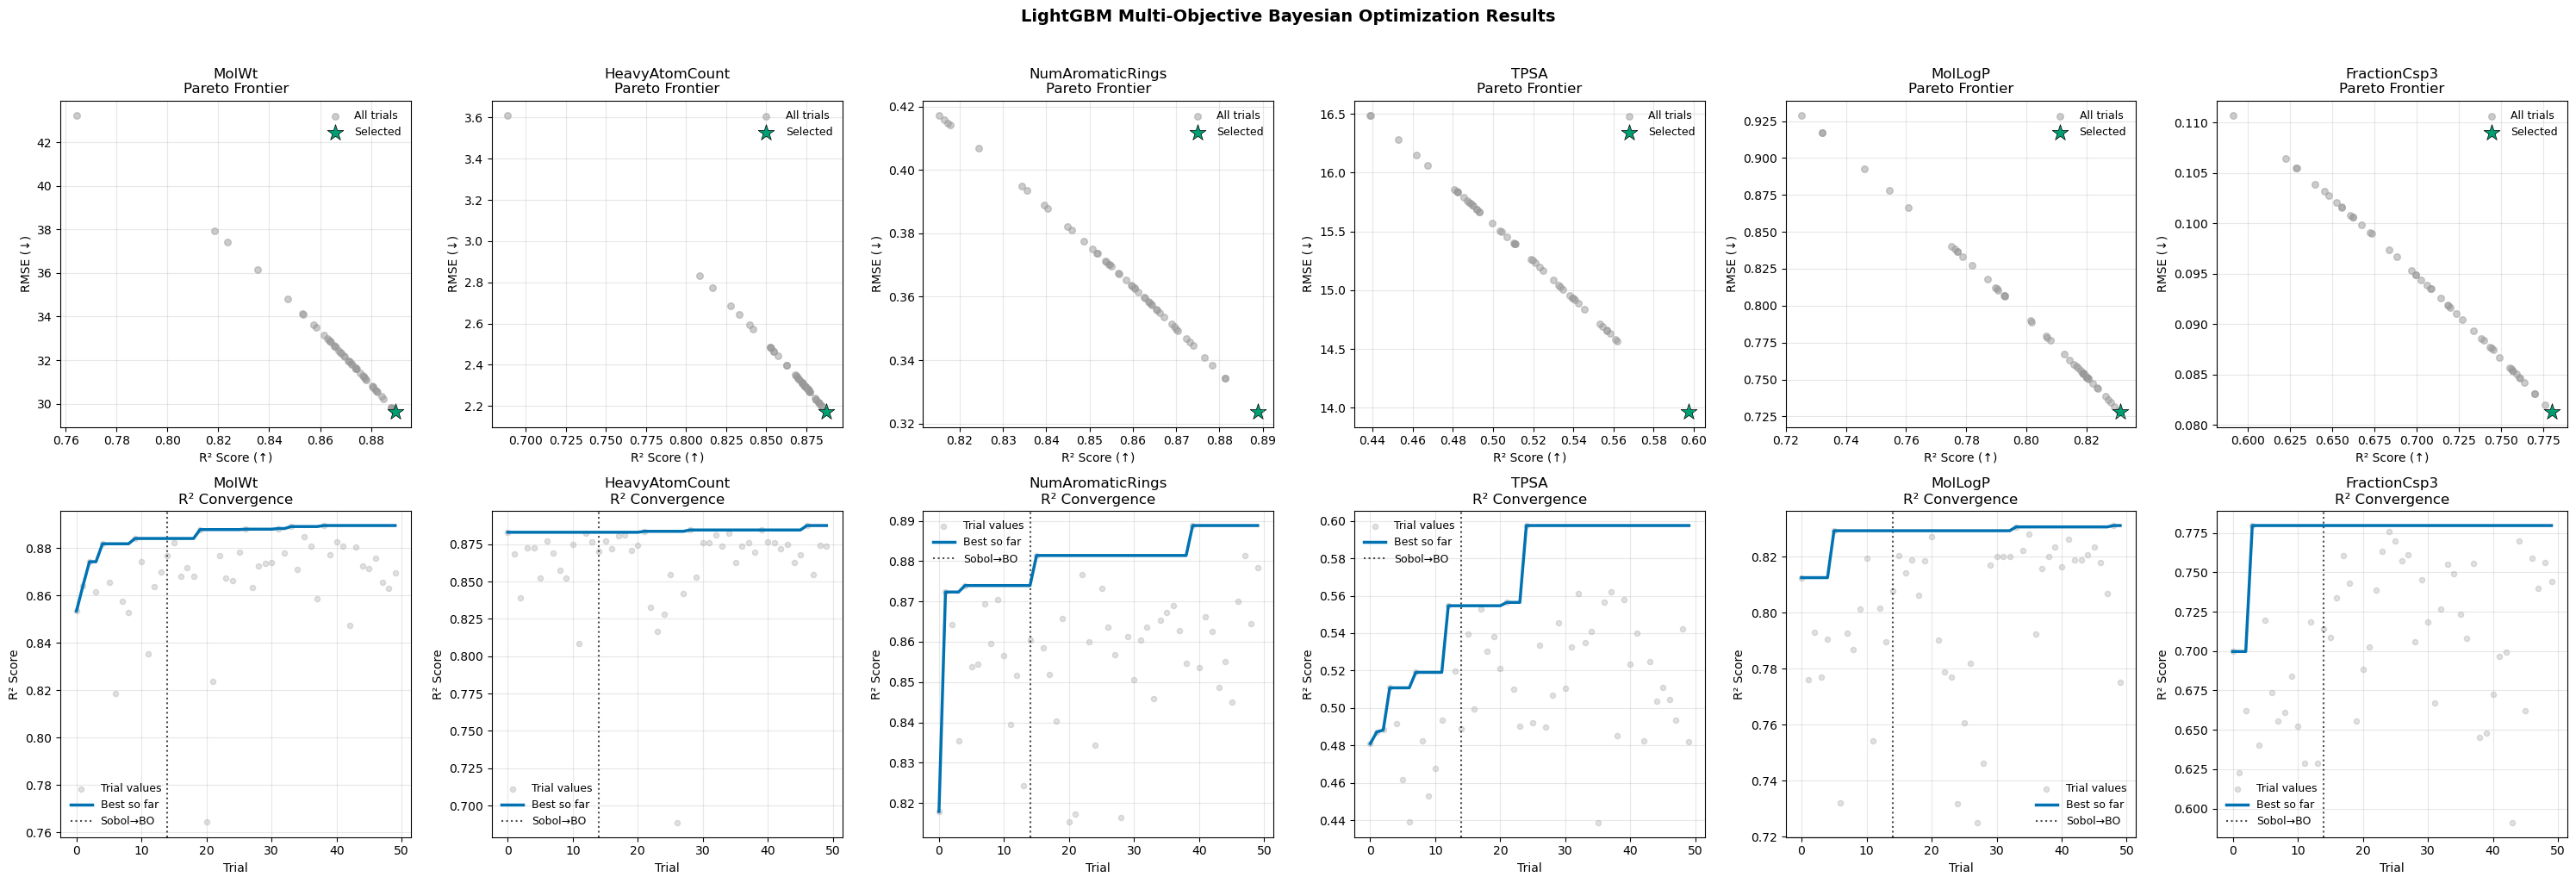

In [19]:
# Colorblind-friendly palette
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

# Set white background style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create a grid visualization for key descriptors
key_descriptors = ['MolWt', 'HeavyAtomCount', 'NumAromaticRings', 'TPSA', 'MolLogP', 'FractionCsp3']
n_show = min(6, len(key_descriptors))

fig, axes = plt.subplots(2, n_show, figsize=(5*n_show, 10))

for idx, descriptor_name in enumerate(key_descriptors[:n_show]):
    if descriptor_name in optimization_results:
        result = optimization_results[descriptor_name]
        df_trials = pd.DataFrame(result['trials_data'])
        
        # Top plot: Pareto frontier
        ax = axes[0, idx]
        ax.scatter(df_trials['r2'], df_trials['rmse'], 
                  alpha=0.5, color=PALETTE["grey"], s=30, label='All trials')
        
        # Highlight best
        ax.scatter(result['best_r2'], result['best_rmse'],
                  color=PALETTE["green"], s=200, marker='*',
                  edgecolor=PALETTE["black"], linewidth=0.5, label='Selected')
        
        ax.set_xlabel('R² Score (↑)')
        ax.set_ylabel('RMSE (↓)')
        ax.set_title(f'{descriptor_name}\nPareto Frontier')
        ax.legend(frameon=False, fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Bottom plot: Convergence
        ax = axes[1, idx]
        r2_history = df_trials['r2'].values
        best_r2_history = np.maximum.accumulate(r2_history)
        
        ax.scatter(range(len(r2_history)), r2_history,
                  alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
        ax.plot(best_r2_history, color=PALETTE["blue"], linewidth=2.5,
                label='Best so far', zorder=5)
        ax.axvline(config.n_initial_points, color=PALETTE["black"],
                  linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
        
        ax.set_xlabel('Trial')
        ax.set_ylabel('R² Score')
        ax.set_title(f'{descriptor_name}\nR² Convergence')
        ax.legend(frameon=False, fontsize=9)
        ax.grid(True, alpha=0.3)

plt.suptitle('LightGBM Multi-Objective Bayesian Optimization Results', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

plot_path = config.results_dir / 'optimization_results.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 11. Performance Summary

Generate comprehensive performance summary across all optimized descriptors.

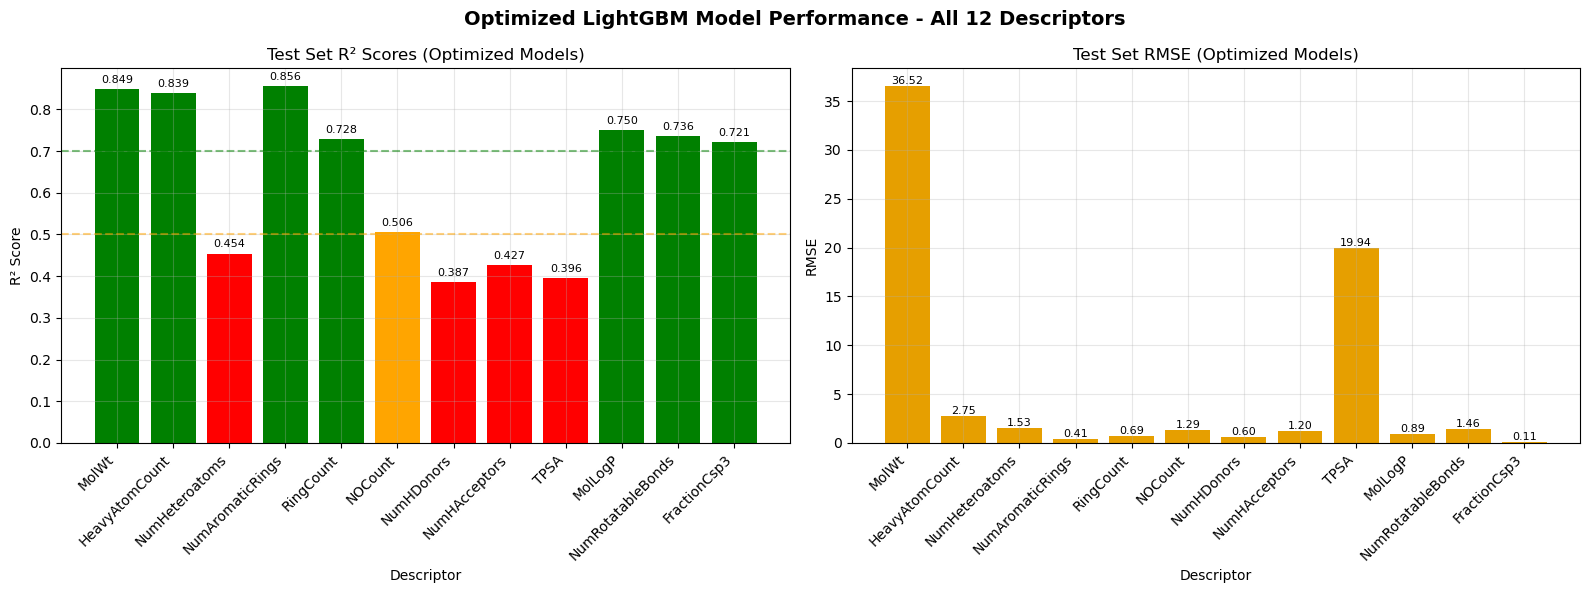

In [20]:
# Create performance summary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
descriptors = list(test_metrics.keys())
r2_scores = [test_metrics[d]['r2'] for d in descriptors]

colors = ['green' if r2 > 0.7 else 'orange' if r2 > 0.5 else 'red' for r2 in r2_scores]
bars = ax1.bar(range(len(descriptors)), r2_scores, color=colors)

ax1.set_xlabel('Descriptor')
ax1.set_ylabel('R² Score')
ax1.set_title('Test Set R² Scores (Optimized Models)')
ax1.set_xticks(range(len(descriptors)))
ax1.set_xticklabels(descriptors, rotation=45, ha='right')
ax1.axhline(y=0.7, color='green', linestyle='--', alpha=0.5)
ax1.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)

for bar, r2 in zip(bars, r2_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{r2:.3f}', ha='center', va='bottom', fontsize=8)

# RMSE comparison
rmse_scores = [test_metrics[d]['rmse'] for d in descriptors]
bars2 = ax2.bar(range(len(descriptors)), rmse_scores, color=PALETTE["orange"])

ax2.set_xlabel('Descriptor')
ax2.set_ylabel('RMSE')
ax2.set_title('Test Set RMSE (Optimized Models)')
ax2.set_xticks(range(len(descriptors)))
ax2.set_xticklabels(descriptors, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

for bar, rmse in zip(bars2, rmse_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{rmse:.2f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Optimized LightGBM Model Performance - All 12 Descriptors', fontsize=14, fontweight='bold')
plt.tight_layout()

summary_plot_path = config.results_dir / 'performance_summary.png'
plt.savefig(summary_plot_path, dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 12. Save Final Results and Generate Report

In [21]:
# Compile all results
all_results = {
    'optimization_config': vars(config),
    'optimization_results': optimization_results,
    'test_metrics': test_metrics,
    'final_models': final_models,
    'data_shapes': {
        'train': data['X_train'].shape,
        'val': data['X_val'].shape,
        'test': data['X_test'].shape
    },
    'feature_names': data['feature_names']
}

# Save comprehensive results
results_path = config.results_dir / 'all_optimization_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(all_results, f)
logger.info(f"All results saved to: {results_path}")

# Generate summary report
report_path = config.results_dir / 'optimization_report.txt'
with open(report_path, 'w') as f:
    f.write("LIGHTGBM MULTI-OBJECTIVE BAYESIAN OPTIMIZATION REPORT\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("OPTIMIZATION CONFIGURATION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Dataset: {config.dataset}\n")
    f.write(f"Descriptors optimized: {len(config.optimize_descriptors)}\n")
    f.write(f"Total trials per descriptor: {config.n_iterations}\n")
    f.write(f"Initial points (Sobol): {config.n_initial_points}\n")
    f.write(f"Batch size: {config.batch_size}\n")
    f.write(f"Subsample fraction: {config.row_subsample_frac}\n\n")
    
    f.write("OPTIMIZATION RESULTS\n")
    f.write("-" * 30 + "\n")
    for descriptor_name in config.optimize_descriptors:
        result = optimization_results[descriptor_name]
        f.write(f"\n{descriptor_name}:\n")
        f.write(f"  Optimization time: {result['optimization_time']:.1f}s\n")
        f.write(f"  Best validation R²: {result['best_r2']:.4f}\n")
        f.write(f"  Best validation RMSE: {result['best_rmse']:.4f}\n")
        f.write(f"  Test R²: {test_metrics[descriptor_name]['r2']:.4f}\n")
        f.write(f"  Test RMSE: {test_metrics[descriptor_name]['rmse']:.4f}\n")
        f.write(f"  Best parameters:\n")
        for param, value in result['best_parameters'].items():
            f.write(f"    {param}: {value}\n")
    
    f.write("\nAGGREGATE STATISTICS\n")
    f.write("-" * 30 + "\n")
    mean_r2 = np.mean([test_metrics[d]['r2'] for d in config.optimize_descriptors])
    median_r2 = np.median([test_metrics[d]['r2'] for d in config.optimize_descriptors])
    f.write(f"Mean test R²: {mean_r2:.4f}\n")
    f.write(f"Median test R²: {median_r2:.4f}\n")
    
    best_desc = max(test_metrics, key=lambda k: test_metrics[k]['r2'])
    worst_desc = min(test_metrics, key=lambda k: test_metrics[k]['r2'])
    f.write(f"Best performing descriptor: {best_desc} (R² = {test_metrics[best_desc]['r2']:.4f})\n")
    f.write(f"Worst performing descriptor: {worst_desc} (R² = {test_metrics[worst_desc]['r2']:.4f})\n")
    
    # Performance categorization
    high_perf = [d for d, m in test_metrics.items() if m['r2'] > 0.7]
    mod_perf = [d for d, m in test_metrics.items() if 0.5 < m['r2'] <= 0.7]
    low_perf = [d for d, m in test_metrics.items() if m['r2'] <= 0.5]
    
    f.write("\nPERFORMANCE DISTRIBUTION\n")
    f.write("-" * 30 + "\n")
    f.write(f"High performance (R² > 0.7): {len(high_perf)}/{len(config.optimize_descriptors)} descriptors\n")
    if high_perf:
        f.write(f"  {', '.join(high_perf)}\n")
    f.write(f"Moderate performance (0.5 < R² ≤ 0.7): {len(mod_perf)}/{len(config.optimize_descriptors)} descriptors\n")
    if mod_perf:
        f.write(f"  {', '.join(mod_perf)}\n")
    f.write(f"Low performance (R² ≤ 0.5): {len(low_perf)}/{len(config.optimize_descriptors)} descriptors\n")
    if low_perf:
        f.write(f"  {', '.join(low_perf)}\n")

logger.info(f"Report saved to: {report_path}")

print("\n" + "=" * 60)
print("OPTIMIZATION COMPLETE")
print("=" * 60)
print(f"\nOptimized {len(config.optimize_descriptors)} descriptors")
print(f"\nTest Set Performance Summary:")
print("-" * 30)
for descriptor_name in config.optimize_descriptors:
    print(f"{descriptor_name:20s}: R² = {test_metrics[descriptor_name]['r2']:.4f}, RMSE = {test_metrics[descriptor_name]['rmse']:.4f}")
print("-" * 30)
print(f"Mean test R²: {mean_r2:.4f}")
print(f"Median test R²: {median_r2:.4f}")
print(f"\nAll results saved to {config.results_dir}")
print("=" * 60)

2025-08-21 09:20:30,726 - INFO - All results saved to: ../data/results/hpo_lgb/all_optimization_results.pkl
2025-08-21 09:20:30,728 - INFO - Report saved to: ../data/results/hpo_lgb/optimization_report.txt



OPTIMIZATION COMPLETE

Optimized 12 descriptors

Test Set Performance Summary:
------------------------------
MolWt               : R² = 0.8487, RMSE = 36.5245
HeavyAtomCount      : R² = 0.8387, RMSE = 2.7479
NumHeteroatoms      : R² = 0.4540, RMSE = 1.5335
NumAromaticRings    : R² = 0.8555, RMSE = 0.4078
RingCount           : R² = 0.7280, RMSE = 0.6897
NOCount             : R² = 0.5059, RMSE = 1.2945
NumHDonors          : R² = 0.3866, RMSE = 0.5970
NumHAcceptors       : R² = 0.4266, RMSE = 1.2027
TPSA                : R² = 0.3958, RMSE = 19.9407
MolLogP             : R² = 0.7497, RMSE = 0.8896
NumRotatableBonds   : R² = 0.7361, RMSE = 1.4604
FractionCsp3        : R² = 0.7207, RMSE = 0.1052
------------------------------
Mean test R²: 0.6372
Median test R²: 0.7243

All results saved to ../data/results/hpo_lgb
